# Spotify clustering

In this challenge, we'll be using a dataset from Spotify that contains metadata for songs on the platform.

By metadata we mean info about the song such as name, artists, metrics about it's sound and other musical attributes.

We will use this dataset to try and cluster songs together that are closely related. This is the underlying theory behind how recommender algorithms work on sites such as Spotify, Netflix, etc.

## Data Exploration

Let's first import and take a look at our data.

In [ ]:
import pandas as pd

spotify_df = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/ML_spotify_data.csv')
spotify_df.head()

,name,artists,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo
0,We're For The Dark - Remastered 2010,['Badfinger'],22,0.678,0.559,0.432,0,3,0.0727,-12.696,0.0334,117.674
1,Sixty Years On - Piano Demo,['Elton John'],25,0.456,0.259,0.368,0,6,0.1560,-10.692,0.0280,143.783
2,Got to Find Another Way,['The Guess Who'],21,0.433,0.833,0.724,0,0,0.1700,-9.803,0.0378,84.341
3,Feelin' Alright - Live At The Fillmore East/1970,['Joe Cocker'],22,0.436,0.870,0.914,0,5,0.8550,-6.955,0.0610,174.005
4,Caravan - Take 7,['Van Morrison'],23,0.669,0.564,0.412,0,7,0.4010,-13.095,0.0679,78.716


For the purposes of our analyses, we will only need the numeric features from our dataset. So we are going to select only these and save them in a variable called `spotify_numeric`.

In [ ]:
spotify_numeric = spotify_df.select_dtypes(include=['int64','float64'])

spotify_numeric.head()

,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo
0,22,0.678,0.559,0.432,0,3,0.0727,-12.696,0.0334,117.674
1,25,0.456,0.259,0.368,0,6,0.1560,-10.692,0.0280,143.783
2,21,0.433,0.833,0.724,0,0,0.1700,-9.803,0.0378,84.341
3,22,0.436,0.870,0.914,0,5,0.8550,-6.955,0.0610,174.005
4,23,0.669,0.564,0.412,0,7,0.4010,-13.095,0.0679,78.716


Spotify generate their own features that relate to abstract characteristcs that can be attributed to a piece of music (e.g. 'valence' or 'danceability').

Then we also have some information that is more literal such as the 'key', 'tempo' and whether a song is 'explicit' or not.

With these informations, we could ask ourselves :

- What is the ratio of explicit vs non-explicit songs?
- How is popularity distributed?
- How are Spotify's internal song metrics distributed?

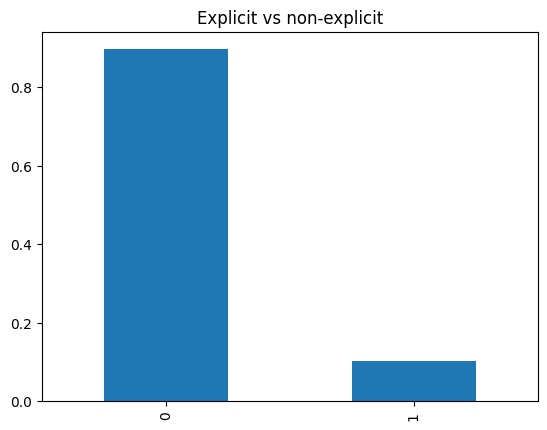

In [ ]:
import matplotlib.pyplot as plt

spotify_numeric.explicit.value_counts(normalize=True).plot(kind='bar');
plt.title('Explicit vs non-explicit');

This graph shows that most of the songs are explicit.

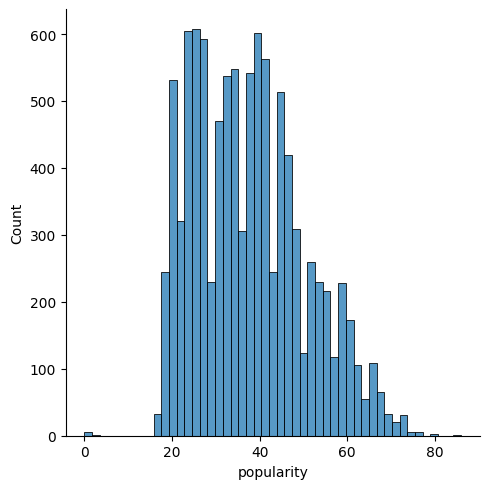

In [ ]:
import seaborn as sns

sns.displot(spotify_numeric['popularity']);

This one shows that most of the popularity of the songs are between 20 and 45.

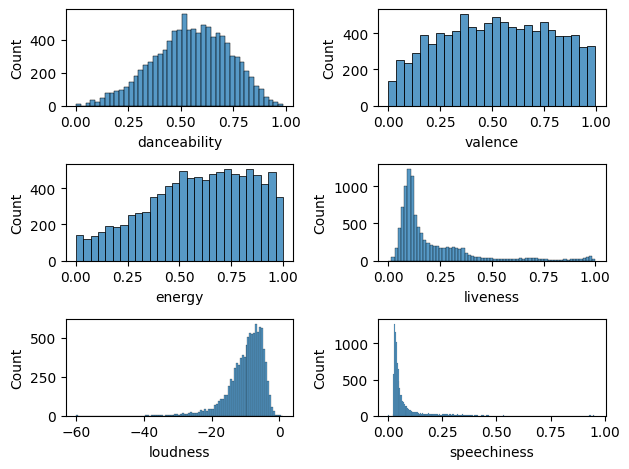

In [ ]:
import numpy as np

fig, axs = plt.subplots(3,2)

var_list = ['danceability','valence','energy','liveness','loudness','speechiness']

# Loop directly through the axs object and assign titles from the list
for row_axes, row_titles in zip(axs, np.array(var_list).reshape(3, 2)):
    for ax, title in zip(row_axes, row_titles):
        sns.histplot(x=spotify_numeric[title],ax=ax)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

Finally, here are the distributions for all the other features : 'danceability', 'valence', 'energy', 'liveness', 'loudness' and 'speechiness'.

## First model

Our goal in this challenge is to cluster our songs into similar groups, in order to give better recommendations to our customers.

When we train a clustering model it will cluster our songs in n-dimensional space, where n is the number of features being fed into the model.

Let's start by instantiating a simple KMeans model, with 8 clusters.

We are going to fit this model to our numeric spotify data and save the labels that our model has stored in a variable called `labels_simple`.

In [ ]:
from sklearn.cluster import KMeans

kmeans_simple = KMeans(n_clusters=8,n_init='auto')
kmeans_simple.fit(spotify_numeric)

labels_simple = kmeans_simple.labels_
labels_simple

array([2, 6, 4, ..., 1, 7, 1], dtype=int32)

Now we can answer these quastion :
- What is the distribution of our labels?
- How many songs do we have in each cluster?

In [ ]:
np.unique(labels_simple,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([ 733, 1370, 1843,  887, 1520, 1467, 1436,  744]))

## Preprocessing

Now we are going to preprocessing our features, in order to get the best results for our clustering. We can do this by using the RobustScaler module.

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
spotify_scaled = pd.DataFrame(scaler.fit_transform(spotify_numeric)
                              , columns=spotify_numeric.columns)
spotify_scaled

,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo
0,-0.736842,0.482072,0.080420,-0.475452,0.0,-0.285714,-0.336421,-0.626782,-0.270833,-0.015120
1,-0.578947,-0.402390,-0.618881,-0.640827,0.0,0.142857,0.161339,-0.307496,-0.395833,0.586217
2,-0.789474,-0.494024,0.719114,0.279070,0.0,-0.714286,0.244996,-0.165857,-0.168981,-0.782839
3,-0.736842,-0.482072,0.805361,0.770026,0.0,0.000000,4.338213,0.287899,0.368056,1.282283
4,-0.684211,0.446215,0.092075,-0.527132,0.0,0.285714,1.625336,-0.690353,0.527778,-0.912393
...,...,...,...,...,...,...,...,...,...,...
9995,1.894737,0.912351,0.194639,0.496124,0.0,0.285714,-0.279653,0.806182,0.995370,-0.306357
9996,1.684211,0.637450,0.488345,0.354005,0.0,0.285714,-0.167314,0.436868,0.356481,0.451550
9997,2.105263,0.306773,0.262238,0.625323,0.0,-0.142857,0.770840,1.041345,0.828704,-0.613624
9998,1.789474,0.454183,-0.768065,0.018088,1.0,-0.428571,3.071407,0.255078,6.085648,-0.996712


## Modelling with preprocessed data

Now, let's train and fit a model in the same way that we did above. However, this time we will use the scaled data, and save the labels in a variable called `labels_scaled`

In [ ]:
kmeans_scaled = KMeans(n_clusters = 8, n_init='auto')
kmeans_scaled.fit(spotify_scaled)

labels_scaled = kmeans_scaled.labels_
labels_scaled

array([0, 2, 0, ..., 2, 3, 6], dtype=int32)

Here is a graph representing the clustering with three of our scaled features : 'danceability', 'energy' and 'speechiness'.

In [ ]:
fig_scaled = px.scatter_3d(spotify_scaled,
                           x = 'danceability',
                           y = 'energy',
                           z = 'speechiness',
                           color = labels_scaled,
                           width=500, height=500)
fig_scaled.show()

## Finding the right value for *K*

This graph gives us an overview of our future clustering, but doesn't look perfect.


We have been using 8 clusters for our models so far, but we didn't tested whether this makes sense.

Let's use *the elbow method* to check how many of clusters we should ideally be using for this dataset.



In [ ]:
nb_clusters_to_try = np.arange(1,21,1)
nb_clusters_to_try

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [ ]:
inertias = []

for k in nb_clusters_to_try:
    kmeans = KMeans(n_clusters = k, n_init='auto')
    kmeans.fit(spotify_scaled)
    inertias.append(kmeans.inertia_)

inertias

[100388.99587726666,
 63515.00771185539,
 54904.44513806619,
 47978.16546393997,
 38653.29189249482,
 35058.74028443309,
 32595.57721426787,
 31043.99764096058,
 29589.749648999492,
 28162.328859307712,
 26845.341604113575,
 26128.061225441863,
 25636.734139047745,
 24935.142790939954,
 24414.02460367849,
 23896.689213999198,
 23515.07633606616,
 23077.492687232832,
 22727.64356693707,
 22610.130531795323]

In [ ]:
import plotly.express as px

fig = px.line(y=inertias,
              x=range(1, len(inertias)+1),
              labels={'x': 'nb centroids', 'y':'Inertia'},
              title="Elbow method")
fig.show()

It looks as though have around 6 clusters makes sense with our dataset. Let's create a new KMeans model using 6 clusters and plot it in 3D space using the same process that we did above.

## Creating a model with the ideal number of clusters

In [ ]:
spotify_clusters = 6

kmeans = KMeans(n_clusters = spotify_clusters, n_init='auto', max_iter=300)

kmeans.fit(spotify_scaled)

labelling = kmeans.labels_

fig_scaled = px.scatter_3d(spotify_scaled,
                           x = 'danceability',
                           y = 'energy',
                           z = 'speechiness',
                           color = labels_scaled,
                           width=500, height=500)
fig_scaled.show()

The chart doesn't reveal a whole lot more, but perhaps we can create some theoretical playlists based on our clusters?

Let's add the new labels from our model that has 6 clusters to our original spotify dataframe as a column called 'label'.

In [ ]:
spotify_df['label'] = pd.Series(labelling)

spotify_df.head()

,name,artists,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo,label
0,We're For The Dark - Remastered 2010,['Badfinger'],22,0.678,0.559,0.432,0,3,0.0727,-12.696,0.0334,117.674,3
1,Sixty Years On - Piano Demo,['Elton John'],25,0.456,0.259,0.368,0,6,0.1560,-10.692,0.0280,143.783,3
2,Got to Find Another Way,['The Guess Who'],21,0.433,0.833,0.724,0,0,0.1700,-9.803,0.0378,84.341,3
3,Feelin' Alright - Live At The Fillmore East/1970,['Joe Cocker'],22,0.436,0.870,0.914,0,5,0.8550,-6.955,0.0610,174.005,4
4,Caravan - Take 7,['Van Morrison'],23,0.669,0.564,0.412,0,7,0.4010,-13.095,0.0679,78.716,3


## Generating Spotify playlists based on our clusters!

We should now see the original meta-data for our spotify songs, but **with the added label of which cluster they are located in** based on our KMeans algorithm.

Let's generate 6 playlists (one for each cluster) that contains 15 random songs from that cluster.

Below we have created a dictionary called `daily_mixes`. Inside this dictionary we want to store keys that are the name of the cluster labels, and then as values we want dataframes that only contains the songs from that specific cluster.


In [ ]:
daily_mixes = {}

for num_cluster in np.unique(labelling):

  daily_mixes[num_cluster] = spotify_df[spotify_df['label'] == num_cluster]

In [ ]:
for key,value in daily_mixes.items():
  print("-"*50)
  print(f"Here are some songs for playlist {key}")
  print("-"*50)
  display(value.sample(5)[['name','artists']])

--------------------------------------------------
Here are some songs for playlist 0
--------------------------------------------------


,name,artists
335,No Knock,['Gil Scott-Heron']
2817,Haydi Gel Benimle Ol,['Sezen Aksu']
8415,Knight (feat. Domo Genesis),"['Earl Sweatshirt', 'Domo Genesis']"
6099,Respect,['Tha Dogg Pound']
3953,Namehraboon,['Fataneh']


--------------------------------------------------
Here are some songs for playlist 1
--------------------------------------------------


,name,artists
4756,Sendas Dios Hará,['Juan Carlos Alvarado']
640,Dear Father - Rebuked,['Neil Diamond']
4932,Los Peces En El Rio,['Mannheim Steamroller']
204,Zazueira (with Stanley Turrentine),"['Astrud Gilberto', 'Stanley Turrentine']"
3517,The Friendship Theme,['Bette Midler']


--------------------------------------------------
Here are some songs for playlist 2
--------------------------------------------------


,name,artists
7777,Math and King Solomon,['John Mulaney']
7775,Chase Through the Subway,['John Mulaney']
6525,The Internet Is for Porn,"[""Stephanie D'Abruzzo"", 'Rick Lyon', 'Avenue Q..."
8059,The Parking Ticket,['Patton Oswalt']
6510,Our Favorite Jokes - Remastered,"['Jeff Foxworthy', 'Bill Engvall', 'Ron White'..."


--------------------------------------------------
Here are some songs for playlist 3
--------------------------------------------------


,name,artists
1920,Tomorrow's World - 2005 Digital Remaster,['Killing Joke']
6535,Maldito Pillo,['Grupo Laberinto']
246,I'll Be Your Baby Tonight,['Bob Dylan']
8174,You Don't Know Jack,['Luke Bryan']
4555,Is My Living In Vain,['Xscape']


--------------------------------------------------
Here are some songs for playlist 4
--------------------------------------------------


,name,artists
3135,I Want the One I Can't Have - Live in Boston,['The Smiths']
498,"The Weight - Live At The Academy Of Music, New...",['The Band']
6730,Beautiful Disaster - Live,['Kelly Clarkson']
4408,"The Brothers Come To Egypt / Grovel, Grovel","['Andrew Lloyd Webber', 'Donny Osmond', 'Janet..."
5912,A Different Feeling,['The Avalanches']


--------------------------------------------------
Here are some songs for playlist 5
--------------------------------------------------


,name,artists
7897,Black Mud,['The Black Keys']
602,Pagode em Bras!lia,['Tião Carreiro & Pardinho']
3194,No Matter How High I Get,"['Luther Barnes', 'The Red Budd Gospel Choir']"
6423,Ebolarama,['Every Time I Die']
3108,"Встань, страх преодолей",['Aria']


### Running clustering with DBSCAN

Let's try and run a clustering analysis using [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

With `DBSCAN` we don't need to *a-prior* select the number of clusters we will end up with.


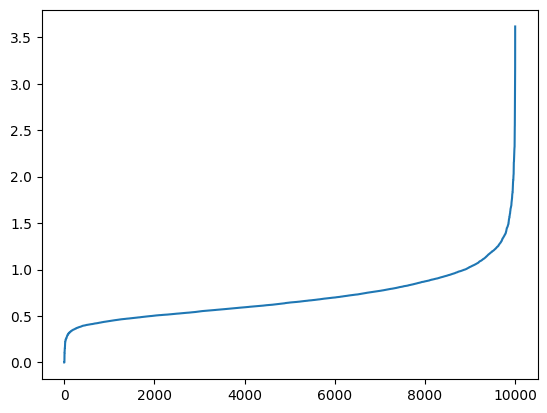

In [ ]:
# Finding the ideal value for epsilon

from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(spotify_scaled)
distances, indices = neighbors_fit.kneighbors(spotify_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances);

# Main crook occurs at approx. between 1 & 1.5

epsilon = 1.25

In [ ]:
from sklearn.cluster import DBSCAN

# Min samples estimate is calculate here as n_features * 2
min_samples = len(spotify_scaled.columns) * 2

spotify_dbscan = DBSCAN(eps=epsilon,min_samples=min_samples)

spotify_dbscan.fit(spotify_scaled)

DBSCAN(eps=1.25, min_samples=20)

We can see that our model created 5 labels, with a concentrated distribution on the first two values.

Let's save your labels in a variable called `dbscan_labels`.

In [ ]:
dbscan_labels = spotify_dbscan.labels_

np.unique(dbscan_labels, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([1506, 8370,   70,   21,   33]))

Using our fitted model, we cab add our predicted cluster labels for each song to the spotify dataframe in a new column called 'label_dbscan'.


In [ ]:
spotify_df['label_dbscan'] = pd.Series(dbscan_labels)

spotify_df.head()

,name,artists,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo,label,label_dbscan
0,We're For The Dark - Remastered 2010,['Badfinger'],22,0.678,0.559,0.432,0,3,0.0727,-12.696,0.0334,117.674,3,0
1,Sixty Years On - Piano Demo,['Elton John'],25,0.456,0.259,0.368,0,6,0.1560,-10.692,0.0280,143.783,3,0
2,Got to Find Another Way,['The Guess Who'],21,0.433,0.833,0.724,0,0,0.1700,-9.803,0.0378,84.341,3,0
3,Feelin' Alright - Live At The Fillmore East/1970,['Joe Cocker'],22,0.436,0.870,0.914,0,5,0.8550,-6.955,0.0610,174.005,4,0
4,Caravan - Take 7,['Van Morrison'],23,0.669,0.564,0.412,0,7,0.4010,-13.095,0.0679,78.716,3,0


In [ ]:
spotify_df.label_dbscan.value_counts()

 0    8370
-1    1506
 1      70
 3      33
 2      21
Name: label_dbscan, dtype: int64

The cell below will generate some new playlists using the DBSCAN clusters.

In [ ]:
daily_mixes_dbscan = {}

for num_cluster in np.unique(dbscan_labels):

  daily_mixes_dbscan[num_cluster] = spotify_df[spotify_df['label_dbscan'] == num_cluster]


for key,value in daily_mixes_dbscan.items():
  print("-"*50)
  print(f"Here are some songs for playlist {key}")
  print("-"*50)
  display(value.sample(5)[['name','artists']])

--------------------------------------------------
Here are some songs for playlist -1
--------------------------------------------------


,name,artists
9202,I'm Not Her,['Clara Mae']
4657,Things Done Changed - 2005 Remaster,['The Notorious B.I.G.']
1578,Medley: Clean up Woman / Pillow Talk / You Got...,['Betty Wright']
9924,1 2 3 (feat. Blac Youngsta),"['Moneybagg Yo', 'Blac Youngsta']"
9484,I Am Defiant,['The Seige']


--------------------------------------------------
Here are some songs for playlist 0
--------------------------------------------------


,name,artists
4410,Miguel Martínez,"['Chalino Sanchez', 'Los Amables Del Norte']"
2550,Alyson,['Rick Springfield']
3008,Home of the Brave,['Naked Raygun']
5382,Burnin',['Daft Punk']
8321,Good As New,['Vacationer']


--------------------------------------------------
Here are some songs for playlist 1
--------------------------------------------------


,name,artists
5172,Camay (feat. Raekwon & Cappadonna),"['Ghostface Killah', 'Raekwon', 'Cappadonna']"
4446,Merry Muthafuckin' Xmas,['Eazy-E']
4718,Show & Prove,['Big Daddy Kane']
8807,Of All Things (feat. Too $hort),"['G-Eazy', 'Too $hort']"
6430,Let It Bump,"['Missy Elliott', 'Timbaland']"


--------------------------------------------------
Here are some songs for playlist 2
--------------------------------------------------


,name,artists
9611,Lost Files,['Polo G']
9954,Mean,"['$NOT', 'Flo Milli']"
9873,All Bad (feat. Lil Uzi Vert),"['Future', 'Lil Uzi Vert']"
9168,Overtime,"['ScHoolboy Q', 'Miguel', 'Justine Skye']"
9855,Big Drip,['Fivio Foreign']


--------------------------------------------------
Here are some songs for playlist 3
--------------------------------------------------


,name,artists
9438,4 Min Convo (Favorite Song),['A Boogie Wit da Hoodie']
9234,Hefner,['Tana Mongeau']
9389,Conscience (feat. Future),"['Kodak Black', 'Future']"
9519,Mileage (feat. Chief Keef),"['Playboi Carti', 'Chief Keef']"
9274,Waste of Time,['Snow Tha Product']
